In [61]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.utils.data as data
import torch.nn as nn
%matplotlib inline
plt.ion()
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [62]:
file_path = "/home/jupyter/datasphere/project/AMD.csv"
data = pd.read_csv(file_path)
# Просмотр отфильтрованных данных
display(data.head())


,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,3.302083,3.125000,3.145833,3.145833,219600
1,1980-03-18,0.0,3.125000,2.937500,3.031250,3.031250,727200
2,1980-03-19,0.0,3.083333,3.020833,3.041667,3.041667,295200
3,1980-03-20,0.0,3.062500,3.010417,3.010417,3.010417,159600
4,1980-03-21,0.0,3.020833,2.906250,2.916667,2.916667,130800


In [63]:
# Преобразование столбца Date в формат datetime
data['Date'] = pd.to_datetime(data['Date'])

# Удаление ненужных столбцов
data = data.drop(columns=['Adj Close', 'Volume'])

# Сортировка данных по дате, если не отсортированы
data = data.sort_values(by='Date')

# Нормализация данных (столбцы Open, High, Low, Close)
scaler = MinMaxScaler()
data[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close']])

# Проверка результатов
print(data.head())

        Date  Open      High       Low     Close
0 1980-03-17   0.0  0.009904  0.009806  0.009519
1 1980-03-18   0.0  0.008816  0.008593  0.008804
2 1980-03-19   0.0  0.008560  0.009132  0.008869
3 1980-03-20   0.0  0.008432  0.009065  0.008674
4 1980-03-21   0.0  0.008176  0.008391  0.008090


In [64]:
sequence_length = 10  # Длина последовательности
X, y = [], []

# Преобразование данных в массив
values = data[['Open', 'High', 'Low', 'Close']].values
target = data['Close'].values  # Для предсказания столбца Close

# Формирование последовательностей
for i in range(len(values) - sequence_length):
    X.append(values[i:i + sequence_length])  # Последовательность входных данных
    y.append(target[i + sequence_length])   # Следующее значение Close

X = np.array(X)
y = np.array(y)

print("Форма входных данных (X):", X.shape)
print("Форма целевых данных (y):", y.shape)


Форма входных данных (X): (10627, 10, 4)
Форма целевых данных (y): (10627,)


In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Обучающая выборка:", X_train.shape, y_train.shape)
print("Тестовая выборка:", X_test.shape, y_test.shape)

Обучающая выборка: (8501, 10, 4) (8501,)
Тестовая выборка: (2126, 10, 4) (2126,)


In [66]:
import torch

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # добавляем размерности
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print("Пример обучающих данных в формате тензоров:")
print(X_train_tensor.shape, y_train_tensor.shape)


Пример обучающих данных в формате тензоров:
torch.Size([8501, 10, 4]) torch.Size([8501, 1])


In [67]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x имеет форму (batch_size, sequence_length, input_size)
        out, _ = self.rnn(x)  # out: (batch_size, sequence_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Используем только последнее скрытое состояние
        return out

# Параметры модели
input_size = X_train.shape[2]  # Количество признаков (Open, High, Low, Close)
hidden_size = 64
output_size = 1  # Предсказание одного значения (Close)

model = SimpleRNN(input_size, hidden_size, output_size)
print(model)


SimpleRNN(
  (rnn): RNN(4, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [70]:
# Функция потерь и оптимизатор
criterion = nn.MSELoss()  # Используем среднеквадратичную ошибку
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [68]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x имеет форму (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)  # out: (batch_size, sequence_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Используем только последнее скрытое состояние
        return out

# Создание модели LSTM
hidden_size_lstm = 64
model_lstm = LSTMModel(input_size, hidden_size_lstm, output_size)
print(model_lstm)

LSTMModel(
  (lstm): LSTM(4, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [69]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x имеет форму (batch_size, sequence_length, input_size)
        out, _ = self.gru(x)  # out: (batch_size, sequence_length, hidden_size)
        out = self.fc(out[:, -1, :])  # Используем только последнее скрытое состояние
        return out

# Создание модели GRU
hidden_size_gru = 64
model_gru = GRUModel(input_size, hidden_size_gru, output_size)
print(model_gru)


GRUModel(
  (gru): GRU(4, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [105]:
import torch.optim as optim

class DeepLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.2):
        super(DeepLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM слои с BatchNormalization и Dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # BatchNormalization после LSTM
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        # Fully connected слой
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Регуляризация L2
        self.regularization = nn.MSELoss()

    def forward(self, x):
        # LSTM forward pass
        out, _ = self.lstm(x)
        
        # Получаем выход из последнего временного шага
        out = out[:, -1, :]
        
        # Применяем BatchNormalization
        out = self.batch_norm(out)
        
        # Прогоняем через fully connected слой
        out = self.fc(out)
        return out

# Гиперпараметры
input_size = 4  # количество признаков на каждом временном шаге
hidden_size = 64  # размер скрытого слоя
output_size = 1  # размер выхода
num_layers = 3  # количество слоев LSTM
dropout_rate = 0.3  # вероятность выпадения для Dropout

# Инициализация модели
model_deep = DeepLSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate)

# Оптимизатор
optimizer_deep = optim.Adam(model_deep.parameters(), lr=0.001, weight_decay=1e-4)

# Выводим архитектуру модели
print(model_deep)


DeepLSTMModel(
  (lstm): LSTM(4, 64, num_layers=3, batch_first=True, dropout=0.3)
  (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (regularization): MSELoss()
)


In [72]:
from torch.utils.data import DataLoader, TensorDataset

# Создание DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Функция обучения
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs=20):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                test_loss += loss.item()

        # Записываем потери для последующей визуализации
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        
        # Выводим потери на каждой эпохе
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.6f}, Test Loss: {test_losses[-1]:.6f}")
    
    return train_losses, test_losses

In [109]:
print("Training SimpleRNN...")
train_losses_rnn, test_losses_rnn = train_model(model, optimizer, criterion, train_loader, test_loader, epochs=20)

Training SimpleRNN...
Epoch 1/20, Train Loss: 0.000013, Test Loss: 0.000169
Epoch 2/20, Train Loss: 0.000012, Test Loss: 0.000192
Epoch 3/20, Train Loss: 0.000013, Test Loss: 0.000135
Epoch 4/20, Train Loss: 0.000012, Test Loss: 0.000133
Epoch 5/20, Train Loss: 0.000013, Test Loss: 0.000154
Epoch 6/20, Train Loss: 0.000014, Test Loss: 0.000137
Epoch 7/20, Train Loss: 0.000012, Test Loss: 0.000207
Epoch 8/20, Train Loss: 0.000013, Test Loss: 0.000183
Epoch 9/20, Train Loss: 0.000012, Test Loss: 0.000176
Epoch 10/20, Train Loss: 0.000013, Test Loss: 0.000133
Epoch 11/20, Train Loss: 0.000012, Test Loss: 0.000162
Epoch 12/20, Train Loss: 0.000012, Test Loss: 0.000163
Epoch 13/20, Train Loss: 0.000012, Test Loss: 0.000137
Epoch 14/20, Train Loss: 0.000012, Test Loss: 0.000250
Epoch 15/20, Train Loss: 0.000012, Test Loss: 0.000184
Epoch 16/20, Train Loss: 0.000012, Test Loss: 0.000134
Epoch 17/20, Train Loss: 0.000012, Test Loss: 0.000144
Epoch 18/20, Train Loss: 0.000012, Test Loss: 0.0001

In [110]:
print("Training LSTM...")
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
train_losses_lstm, test_losses_lstm = train_model(model_lstm, optimizer_lstm, criterion, train_loader, test_loader, epochs=20)

Training LSTM...
Epoch 1/20, Train Loss: 0.000013, Test Loss: 0.000184
Epoch 2/20, Train Loss: 0.000013, Test Loss: 0.000143
Epoch 3/20, Train Loss: 0.000012, Test Loss: 0.000169
Epoch 4/20, Train Loss: 0.000012, Test Loss: 0.000357
Epoch 5/20, Train Loss: 0.000012, Test Loss: 0.000234
Epoch 6/20, Train Loss: 0.000012, Test Loss: 0.000167
Epoch 7/20, Train Loss: 0.000011, Test Loss: 0.000342
Epoch 8/20, Train Loss: 0.000011, Test Loss: 0.000318
Epoch 9/20, Train Loss: 0.000012, Test Loss: 0.000153
Epoch 10/20, Train Loss: 0.000012, Test Loss: 0.000148
Epoch 11/20, Train Loss: 0.000012, Test Loss: 0.000230
Epoch 12/20, Train Loss: 0.000012, Test Loss: 0.000280
Epoch 13/20, Train Loss: 0.000011, Test Loss: 0.000149
Epoch 14/20, Train Loss: 0.000011, Test Loss: 0.000178
Epoch 15/20, Train Loss: 0.000011, Test Loss: 0.000162
Epoch 16/20, Train Loss: 0.000012, Test Loss: 0.000254
Epoch 17/20, Train Loss: 0.000011, Test Loss: 0.000211
Epoch 18/20, Train Loss: 0.000011, Test Loss: 0.000161
Ep

In [111]:
print("Training GRU...")
optimizer_gru = torch.optim.Adam(model_gru.parameters(), lr=0.001)
train_losses_gru, test_losses_gru = train_model(model_gru, optimizer_gru, criterion, train_loader, test_loader, epochs=20)

Training GRU...
Epoch 1/20, Train Loss: 0.000014, Test Loss: 0.000171
Epoch 2/20, Train Loss: 0.000012, Test Loss: 0.000211
Epoch 3/20, Train Loss: 0.000012, Test Loss: 0.000254
Epoch 4/20, Train Loss: 0.000012, Test Loss: 0.000310
Epoch 5/20, Train Loss: 0.000012, Test Loss: 0.000226
Epoch 6/20, Train Loss: 0.000012, Test Loss: 0.000143
Epoch 7/20, Train Loss: 0.000013, Test Loss: 0.000175
Epoch 8/20, Train Loss: 0.000012, Test Loss: 0.000170
Epoch 9/20, Train Loss: 0.000011, Test Loss: 0.000209
Epoch 10/20, Train Loss: 0.000011, Test Loss: 0.000218
Epoch 11/20, Train Loss: 0.000011, Test Loss: 0.000171
Epoch 12/20, Train Loss: 0.000012, Test Loss: 0.000175
Epoch 13/20, Train Loss: 0.000012, Test Loss: 0.000135
Epoch 14/20, Train Loss: 0.000011, Test Loss: 0.000197
Epoch 15/20, Train Loss: 0.000012, Test Loss: 0.000205
Epoch 16/20, Train Loss: 0.000012, Test Loss: 0.000143
Epoch 17/20, Train Loss: 0.000011, Test Loss: 0.000233
Epoch 18/20, Train Loss: 0.000011, Test Loss: 0.000219
Epo

In [113]:
print("Training Deep Model...")
train_losses_deep, test_losses_deep = train_model(model_deep, optimizer_deep, criterion, train_loader, test_loader, epochs=20)

Training Deep Model...
Epoch 1/20, Train Loss: 0.000141, Test Loss: 0.000488
Epoch 2/20, Train Loss: 0.000133, Test Loss: 0.000381
Epoch 3/20, Train Loss: 0.000138, Test Loss: 0.000354
Epoch 4/20, Train Loss: 0.000124, Test Loss: 0.000555
Epoch 5/20, Train Loss: 0.000124, Test Loss: 0.001541
Epoch 6/20, Train Loss: 0.000135, Test Loss: 0.000388
Epoch 7/20, Train Loss: 0.000124, Test Loss: 0.000335
Epoch 8/20, Train Loss: 0.000123, Test Loss: 0.000735
Epoch 9/20, Train Loss: 0.000133, Test Loss: 0.000358
Epoch 10/20, Train Loss: 0.000127, Test Loss: 0.000333
Epoch 11/20, Train Loss: 0.000139, Test Loss: 0.001404
Epoch 12/20, Train Loss: 0.000134, Test Loss: 0.000371
Epoch 13/20, Train Loss: 0.000133, Test Loss: 0.000463
Epoch 14/20, Train Loss: 0.000145, Test Loss: 0.001055
Epoch 15/20, Train Loss: 0.000126, Test Loss: 0.000446
Epoch 16/20, Train Loss: 0.000123, Test Loss: 0.000344
Epoch 17/20, Train Loss: 0.000129, Test Loss: 0.000703
Epoch 18/20, Train Loss: 0.000131, Test Loss: 0.001

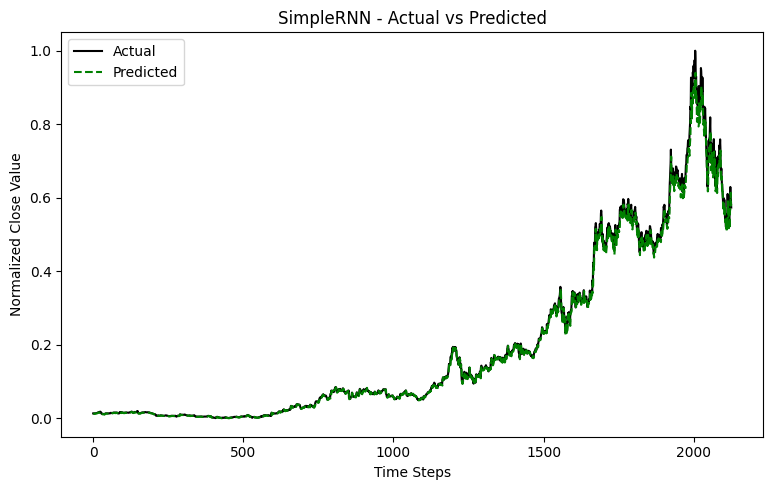

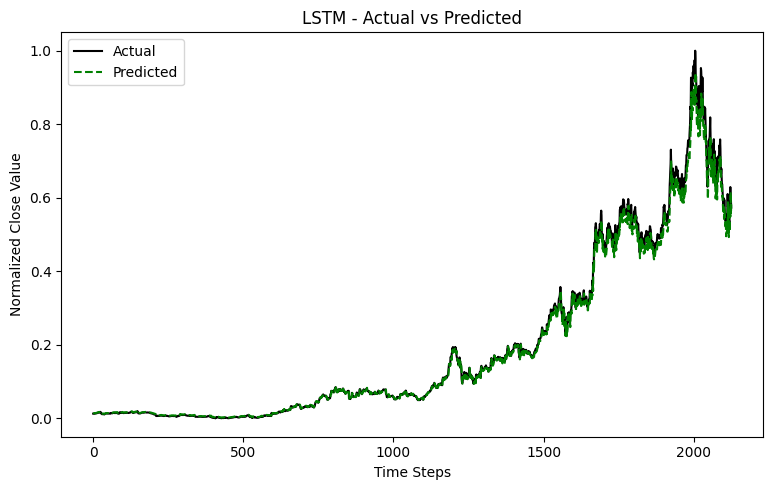

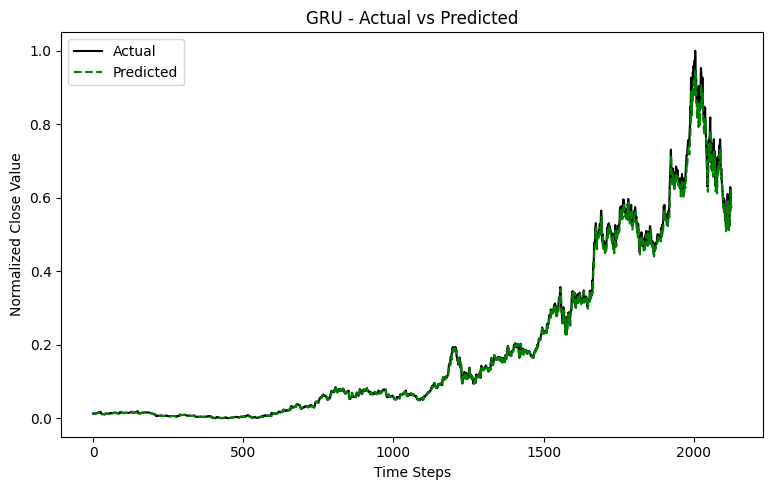

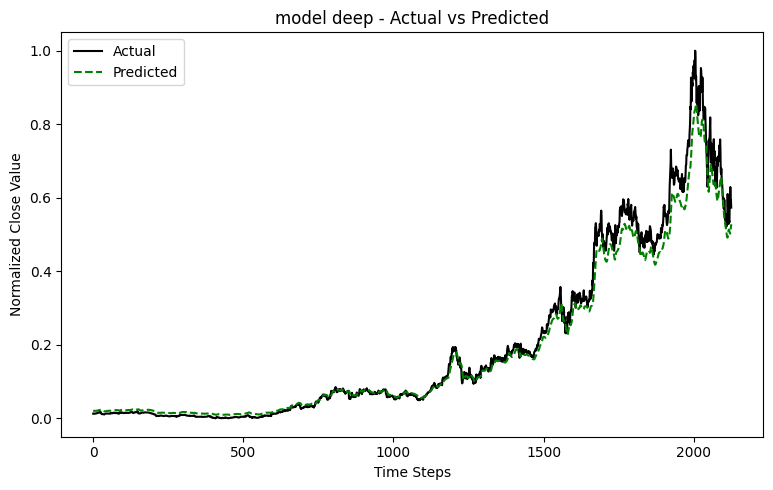

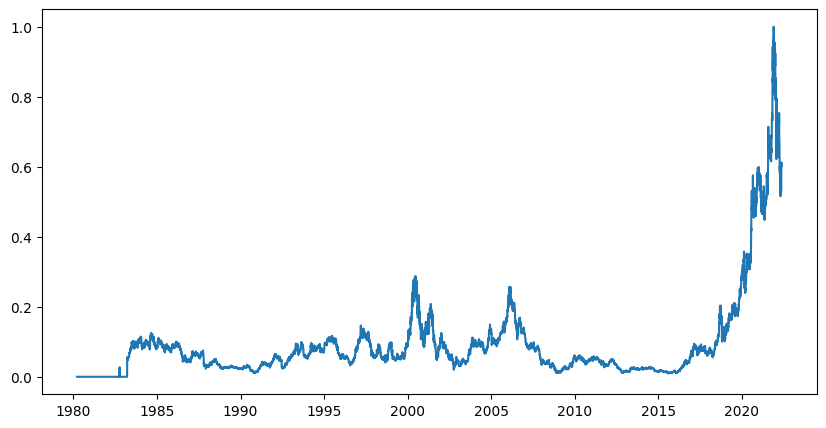

In [124]:
def get_predictions(model, X_tensor):
    model.eval()
    with torch.no_grad():
        return model(X_tensor).numpy()
    
def plot_model_results(model_name, train_losses, test_losses, y_pred_test, y_actual):
    epochs = len(train_losses)

    plt.figure(figsize=(15, 5))

    # # Потери на обучении и проверке
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color="blue")
    # plt.plot(range(1, epochs + 1), test_losses, label="Test Loss", color="orange")
    # plt.title(f"{model_name} - Loss Over Epochs")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.legend()

    # Действительные и предсказанные значения
    plt.subplot(1, 2, 2)
    plt.plot(y_actual, label="Actual", color="black")
    plt.plot(y_pred_test, label="Predicted", linestyle="--", color="green")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Close Value")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Предсказания для каждой модели
y_pred_rnn = get_predictions(model, X_test_tensor)
y_pred_lstm = get_predictions(model_lstm, X_test_tensor)
y_pred_gru = get_predictions(model_gru, X_test_tensor)
y_pred_deep = get_predictions(model_deep, X_test_tensor)
y_actual = y_test_tensor.numpy()

# Построение графиков для каждой 
plot_model_results("SimpleRNN", train_losses_rnn, test_losses_rnn, y_pred_rnn, y_actual)
plot_model_results("LSTM", train_losses_lstm, test_losses_lstm, y_pred_lstm, y_actual)
plot_model_results("GRU", train_losses_gru, test_losses_gru, y_pred_gru, y_actual)
plot_model_results("model deep", train_losses_deep, test_losses_deep, y_pred_deep, y_actual)

In [116]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Вычисление метрик для каждой модели
def compute_metrics(y_actual, y_pred):
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual, y_pred)
    
    return mae, mse, rmse, r2

# Для RNN
mae_rnn, mse_rnn, rmse_rnn, r2_rnn = compute_metrics(y_actual, y_pred_rnn)
# Для LSTM
mae_lstm, mse_lstm, rmse_lstm, r2_lstm = compute_metrics(y_actual, y_pred_lstm)
# Для GRU
mae_gru, mse_gru, rmse_gru, r2_gru = compute_metrics(y_actual, y_pred_gru)
# Для Deep
mae_deep, mse_deep, rmse_deep, r2_deep = compute_metrics(y_actual, y_pred_deep)

# Выводим результаты
print(f"RNN: MAE={mae_rnn:.4f}, MSE={mse_rnn:.4f}, RMSE={rmse_rnn:.4f}, R2={r2_rnn:.4f}")
print(f"LSTM: MAE={mae_lstm:.4f}, MSE={mse_lstm:.4f}, RMSE={rmse_lstm:.4f}, R2={r2_lstm:.4f}")
print(f"GRU: MAE={mae_gru:.4f}, MSE={mse_gru:.4f}, RMSE={rmse_gru:.4f}, R2={r2_gru:.4f}")
print(f"DEEP LSTM: MAE={mae_deep:.4f}, MSE={mse_deep:.4f}, RMSE={rmse_deep:.4f}, R2={r2_deep:.4f}")

RNN: MAE=0.0071, MSE=0.0002, RMSE=0.0146, R2=0.9963
LSTM: MAE=0.0094, MSE=0.0003, RMSE=0.0186, R2=0.9939
GRU: MAE=0.0066, MSE=0.0002, RMSE=0.0139, R2=0.9966
DEEP LSTM: MAE=0.0203, MSE=0.0012, RMSE=0.0346, R2=0.9789


Выводы:
GRU — это, вероятно, наиболее оптимальный выбор среди этих моделей для вашей задачи, так как она имеет минимальные ошибки и максимальное значение R2.
RNN также является хорошим выбором и показывает почти такие же результаты, как и GRU.
LSTM может быть полезной моделью для других задач, где требуется более сложное моделирование временных зависимостей, но для вашего случая она немного хуже, чем GRU и RNN.
Deep LSTM показал наименьшую производительность, что может указывать на проблему с переобучением, возможно, из-за сложности модели.